In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Exploratory Data Analysis**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/DL PROJECT/train.csv')

# Data Overview

print("Dataset Shape:", df.shape)
print("\n First 5 rows:\n", df.head())
print("\n Data Types:\n", df.dtypes)
print("\n Missing Values:\n", df.isnull().sum())
print("\n Summary Statistics:\n", df.describe(include='all'))

Dataset Shape: (20000, 41)

 First 5 rows:
          V1        V2        V3        V4        V5        V6        V7  \
0 -4.464606 -4.679129  3.101546  0.506130 -0.221083 -2.032511 -2.910870   
1  3.365912  3.653381  0.909671 -1.367528  0.332016  2.358938  0.732600   
2 -3.831843 -5.824444  0.634031 -2.418815 -1.773827  1.016824 -2.098941   
3  1.618098  1.888342  7.046143 -1.147285  0.083080 -1.529780  0.207309   
4 -0.111440  3.872488 -3.758361 -2.982897  3.792714  0.544960  0.205433   

         V8        V9       V10  ...       V32       V33        V34       V35  \
0  0.050714 -1.522351  3.761892  ...  3.059700 -1.690440   2.846296  2.235198   
1 -4.332135  0.565695 -0.101080  ... -1.795474  3.032780  -2.467514  1.894599   
2 -3.173204 -2.081860  5.392621  ... -0.257101  0.803550   4.086219  2.292138   
3 -2.493629  0.344926  2.118578  ... -3.584425 -2.577474   1.363769  0.622714   
4  4.848994 -1.854920 -6.220023  ...  8.265896  6.629213 -10.068689  1.222987   

        V36       

# **Important points**

*   Shape: (20000, 41) → 20,000 samples and 41 features.
*   Feature Names: V1 to V40 (all numerical - float64), plus Target (int64).
*   Both V1 & V2 have 18 missing values.







# Univariate Analysis

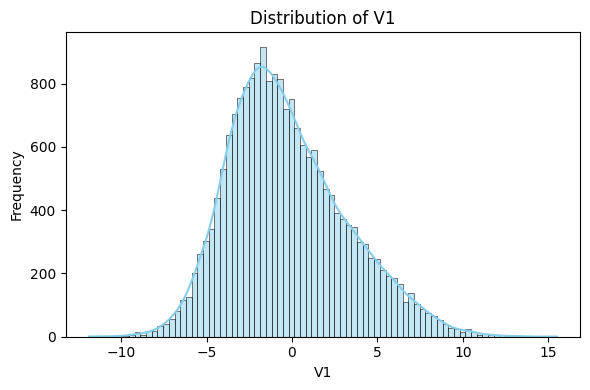

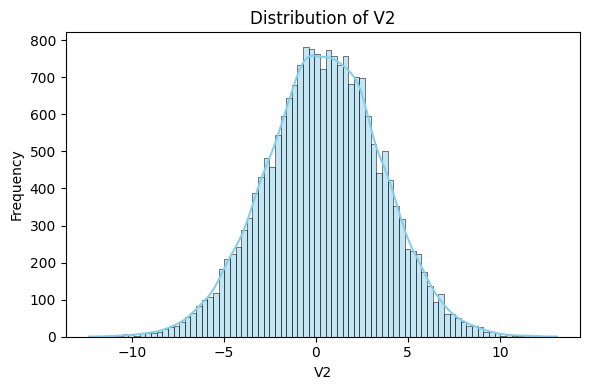

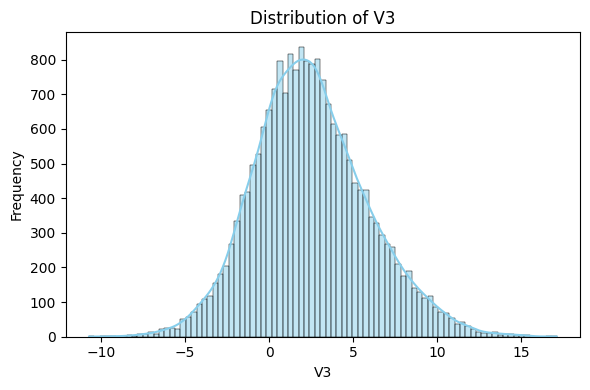

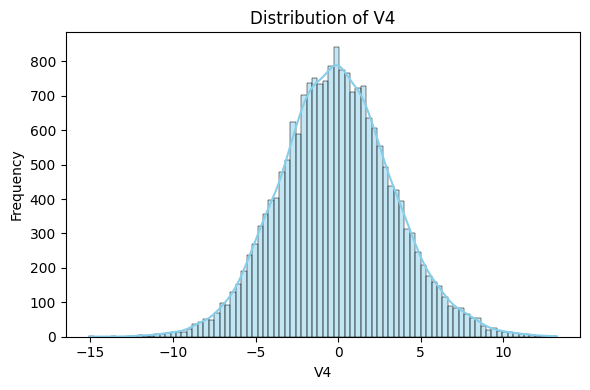

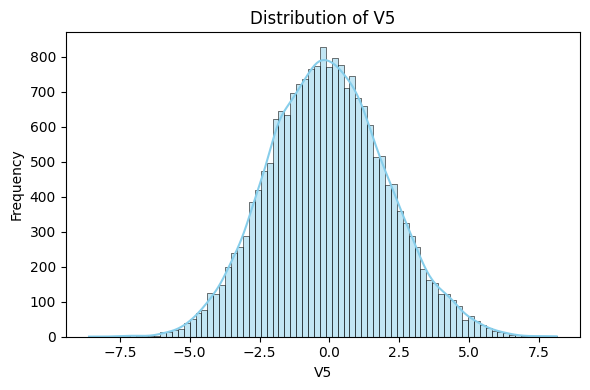

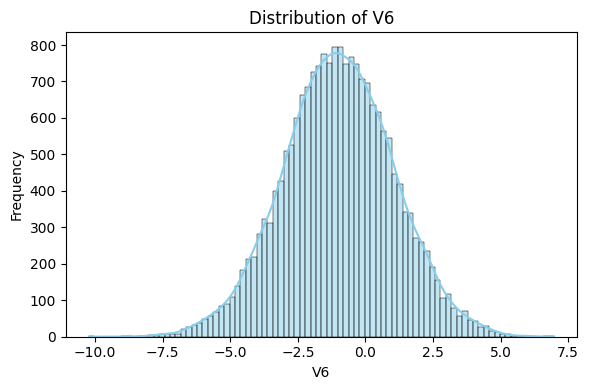

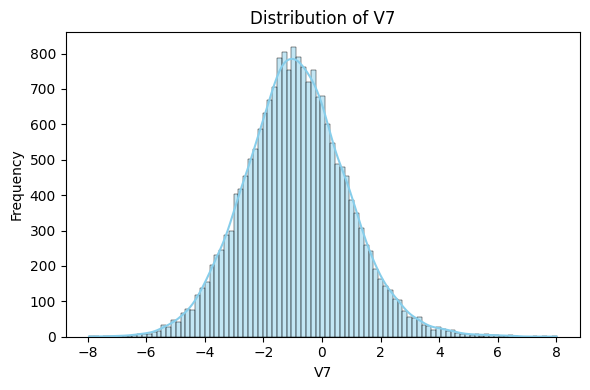

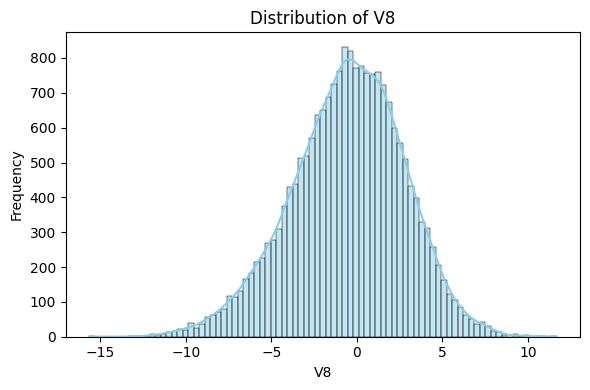

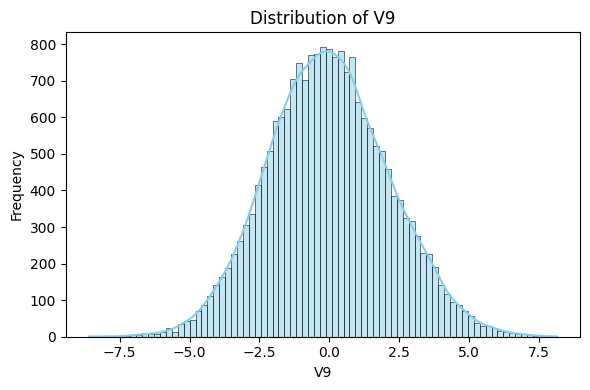

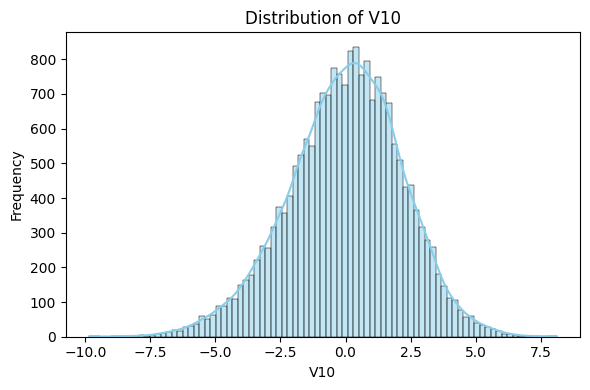

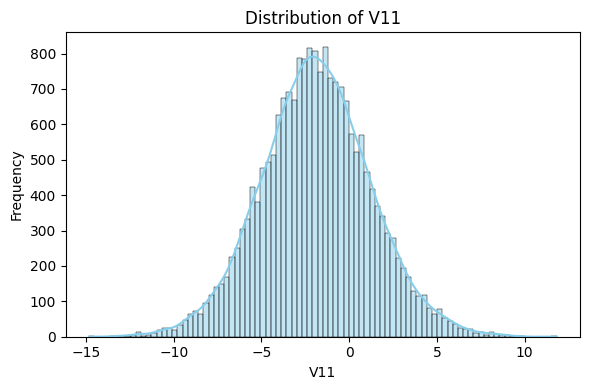

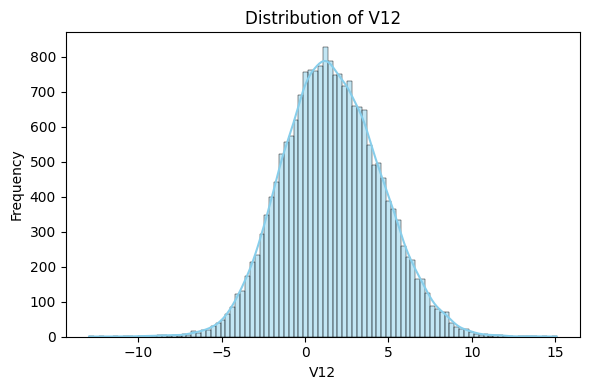

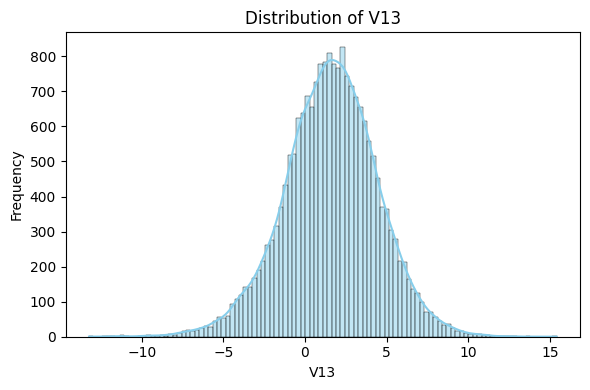

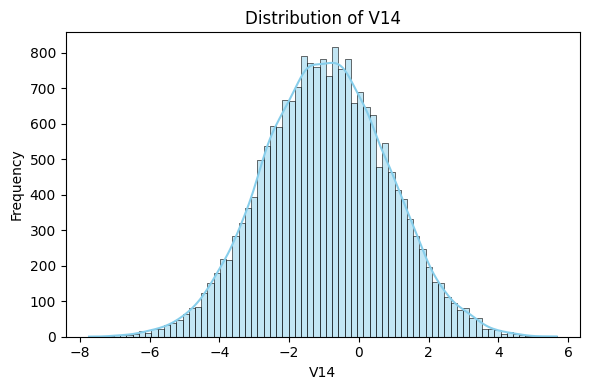

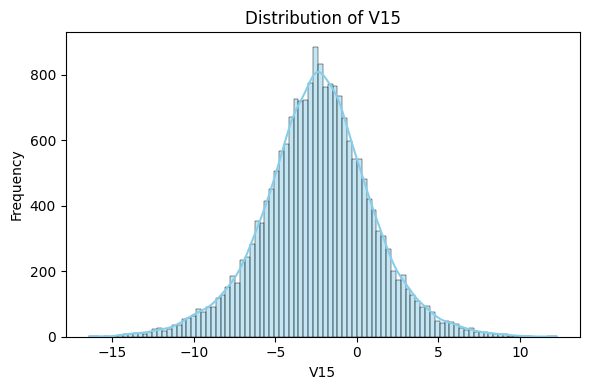

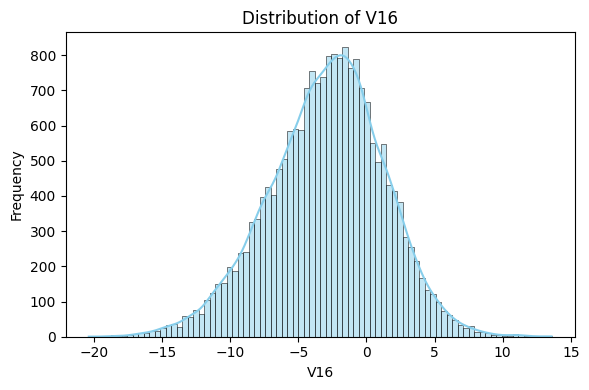

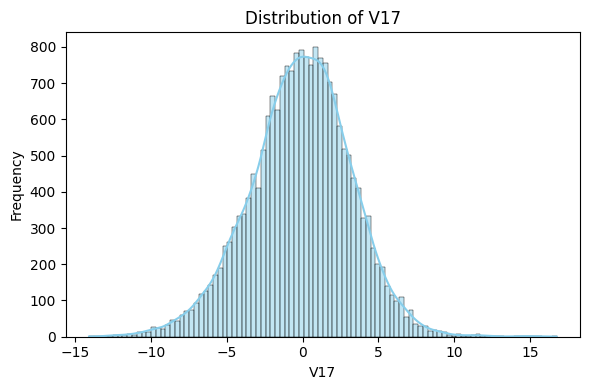

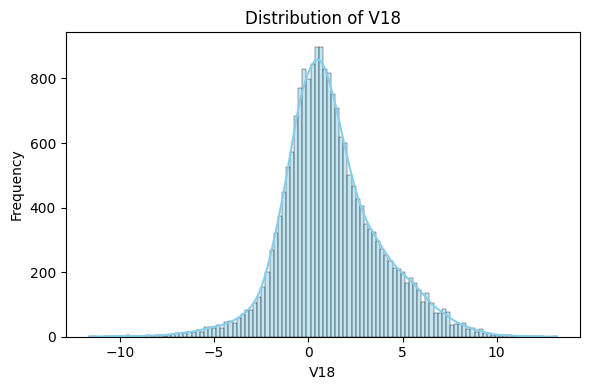

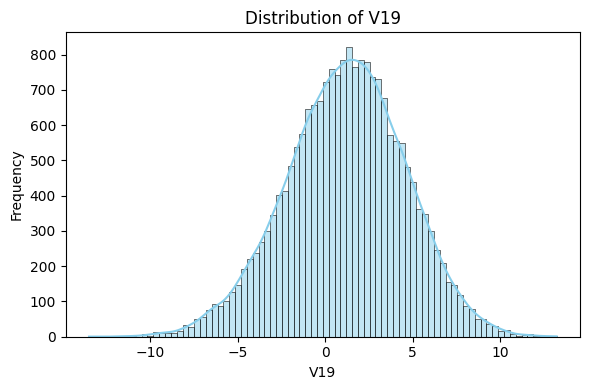

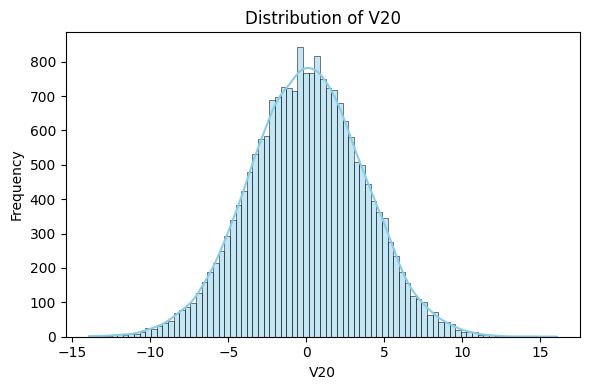

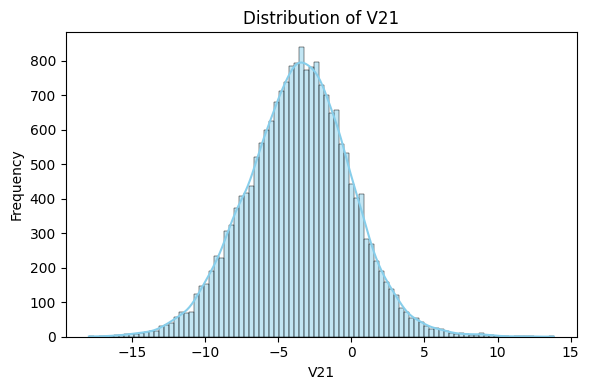

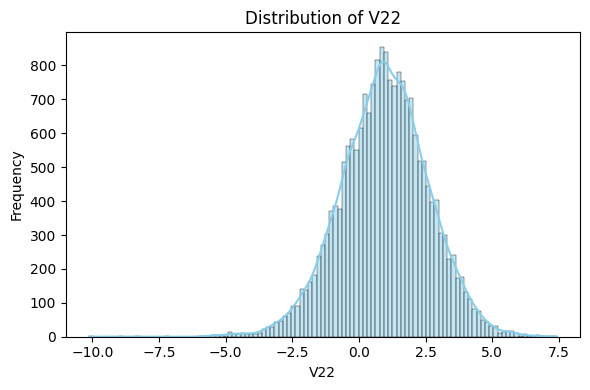

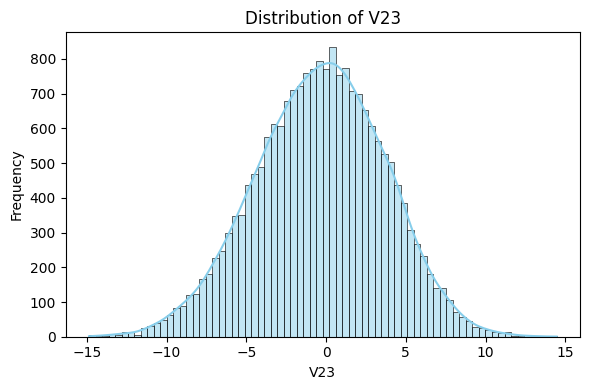

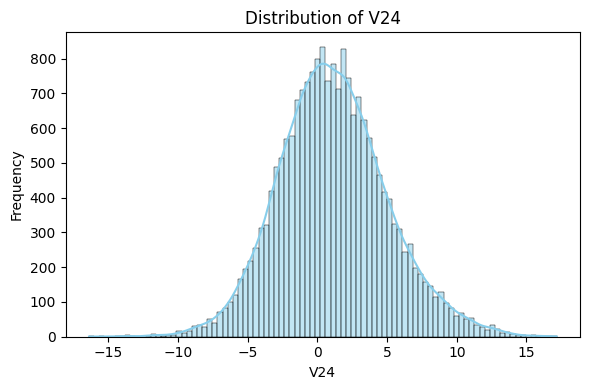

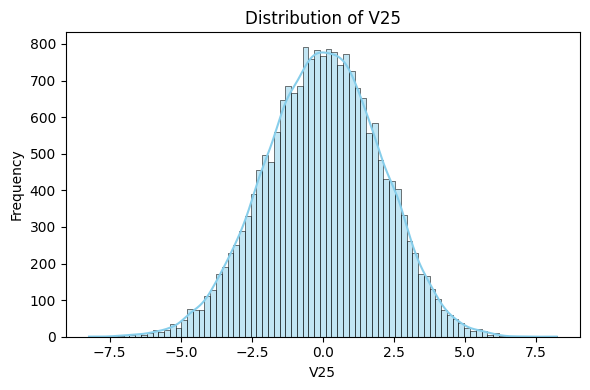

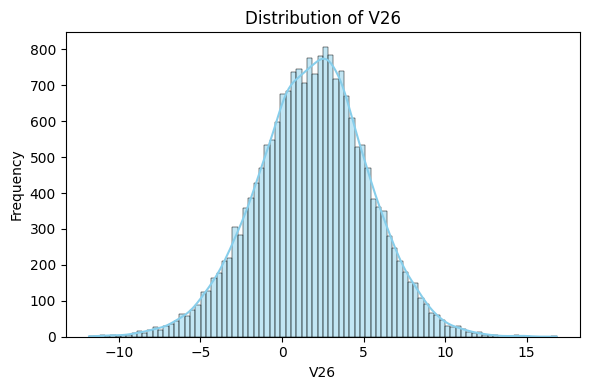

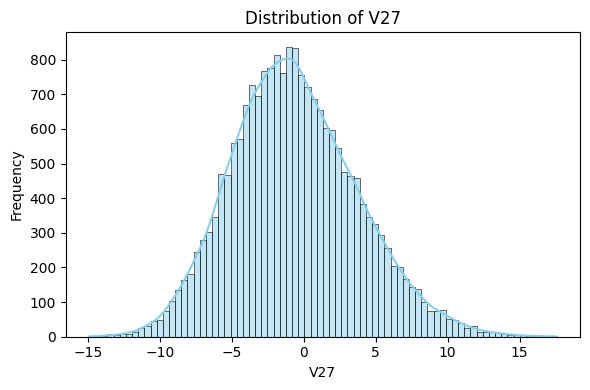

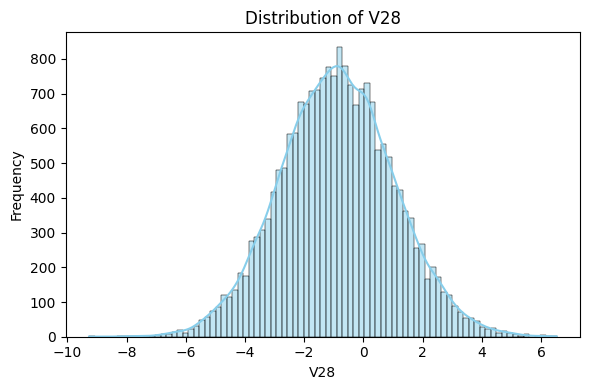

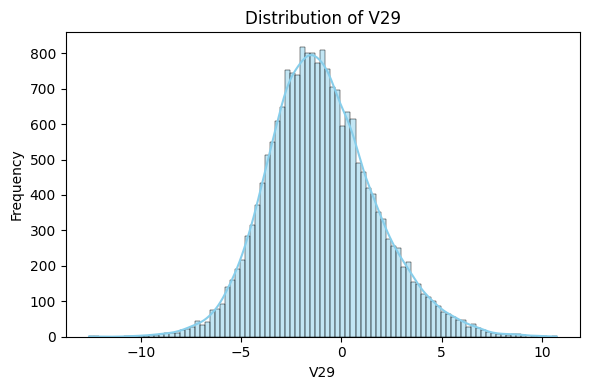

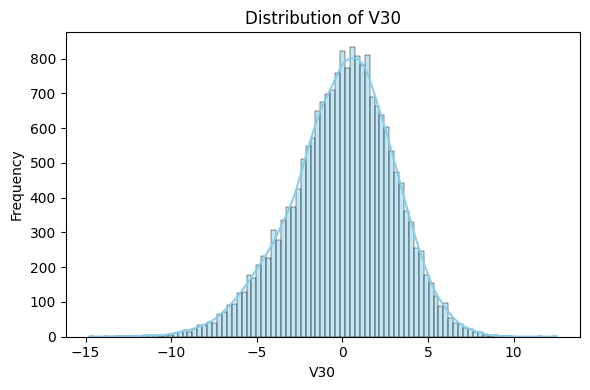

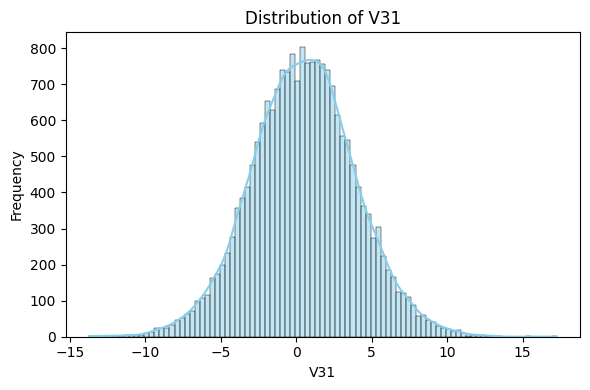

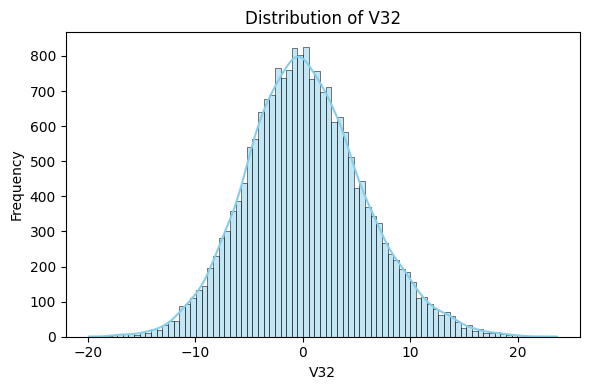

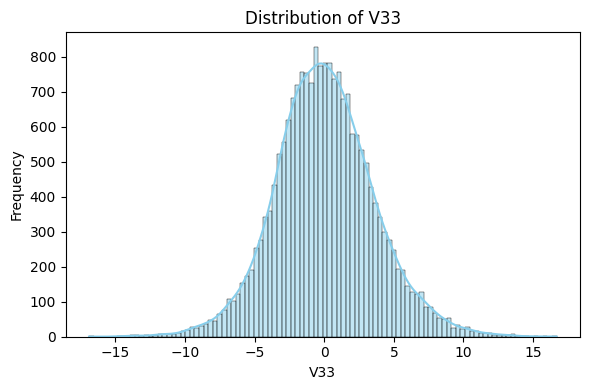

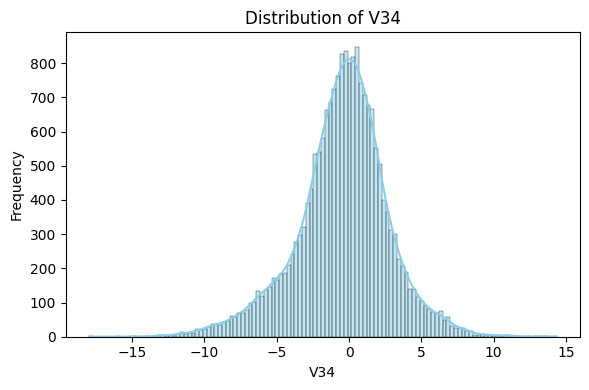

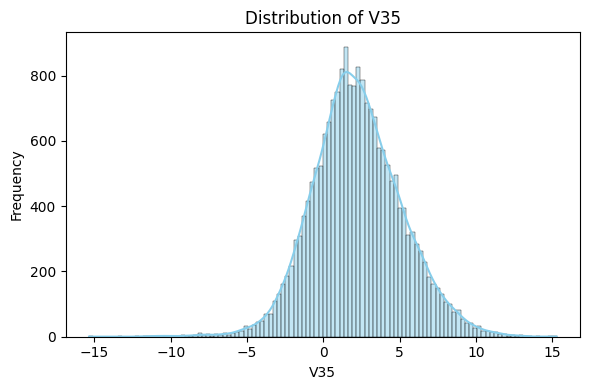

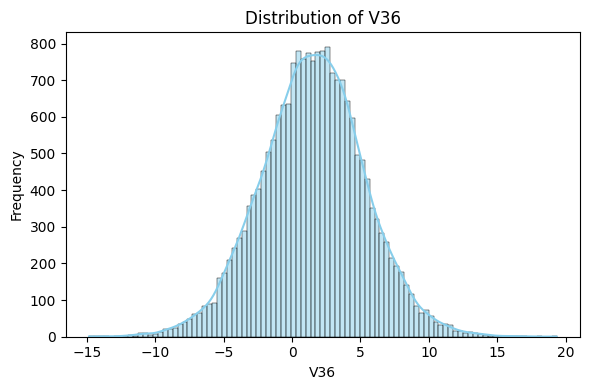

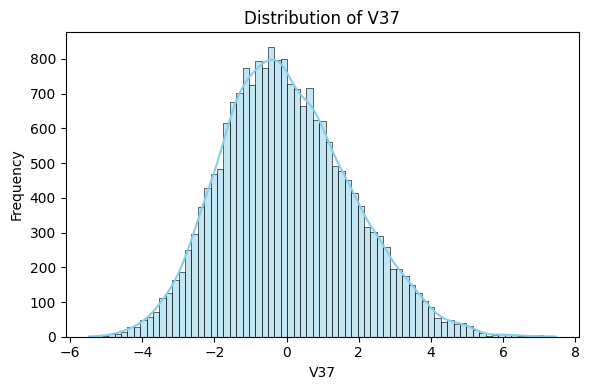

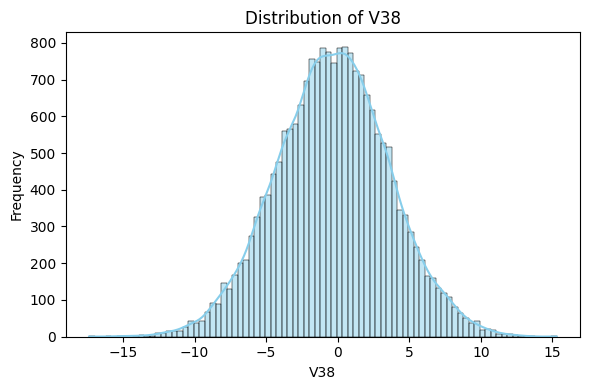

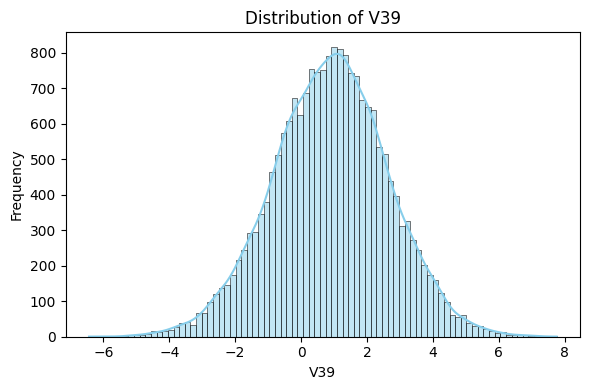

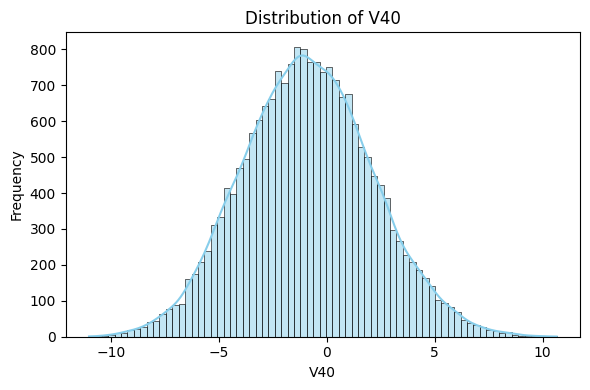

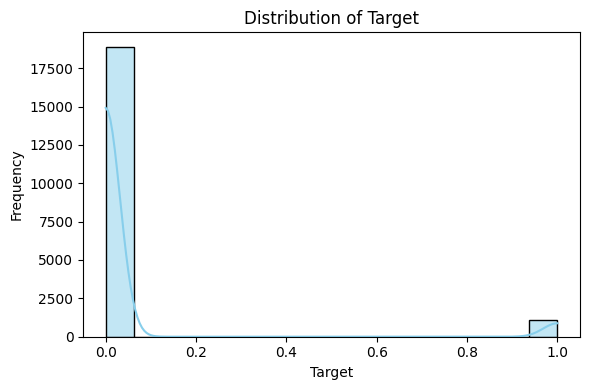

In [ ]:
# For numeric features
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# For categorical features
categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    df[col].value_counts().plot(kind='bar', color='lightgreen')
    plt.title(f'Value Counts of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# **Important point**


*   All (V1 to V40) are normally distributed.
*   Imbalanced Dataset.



# Bivariate Analysis

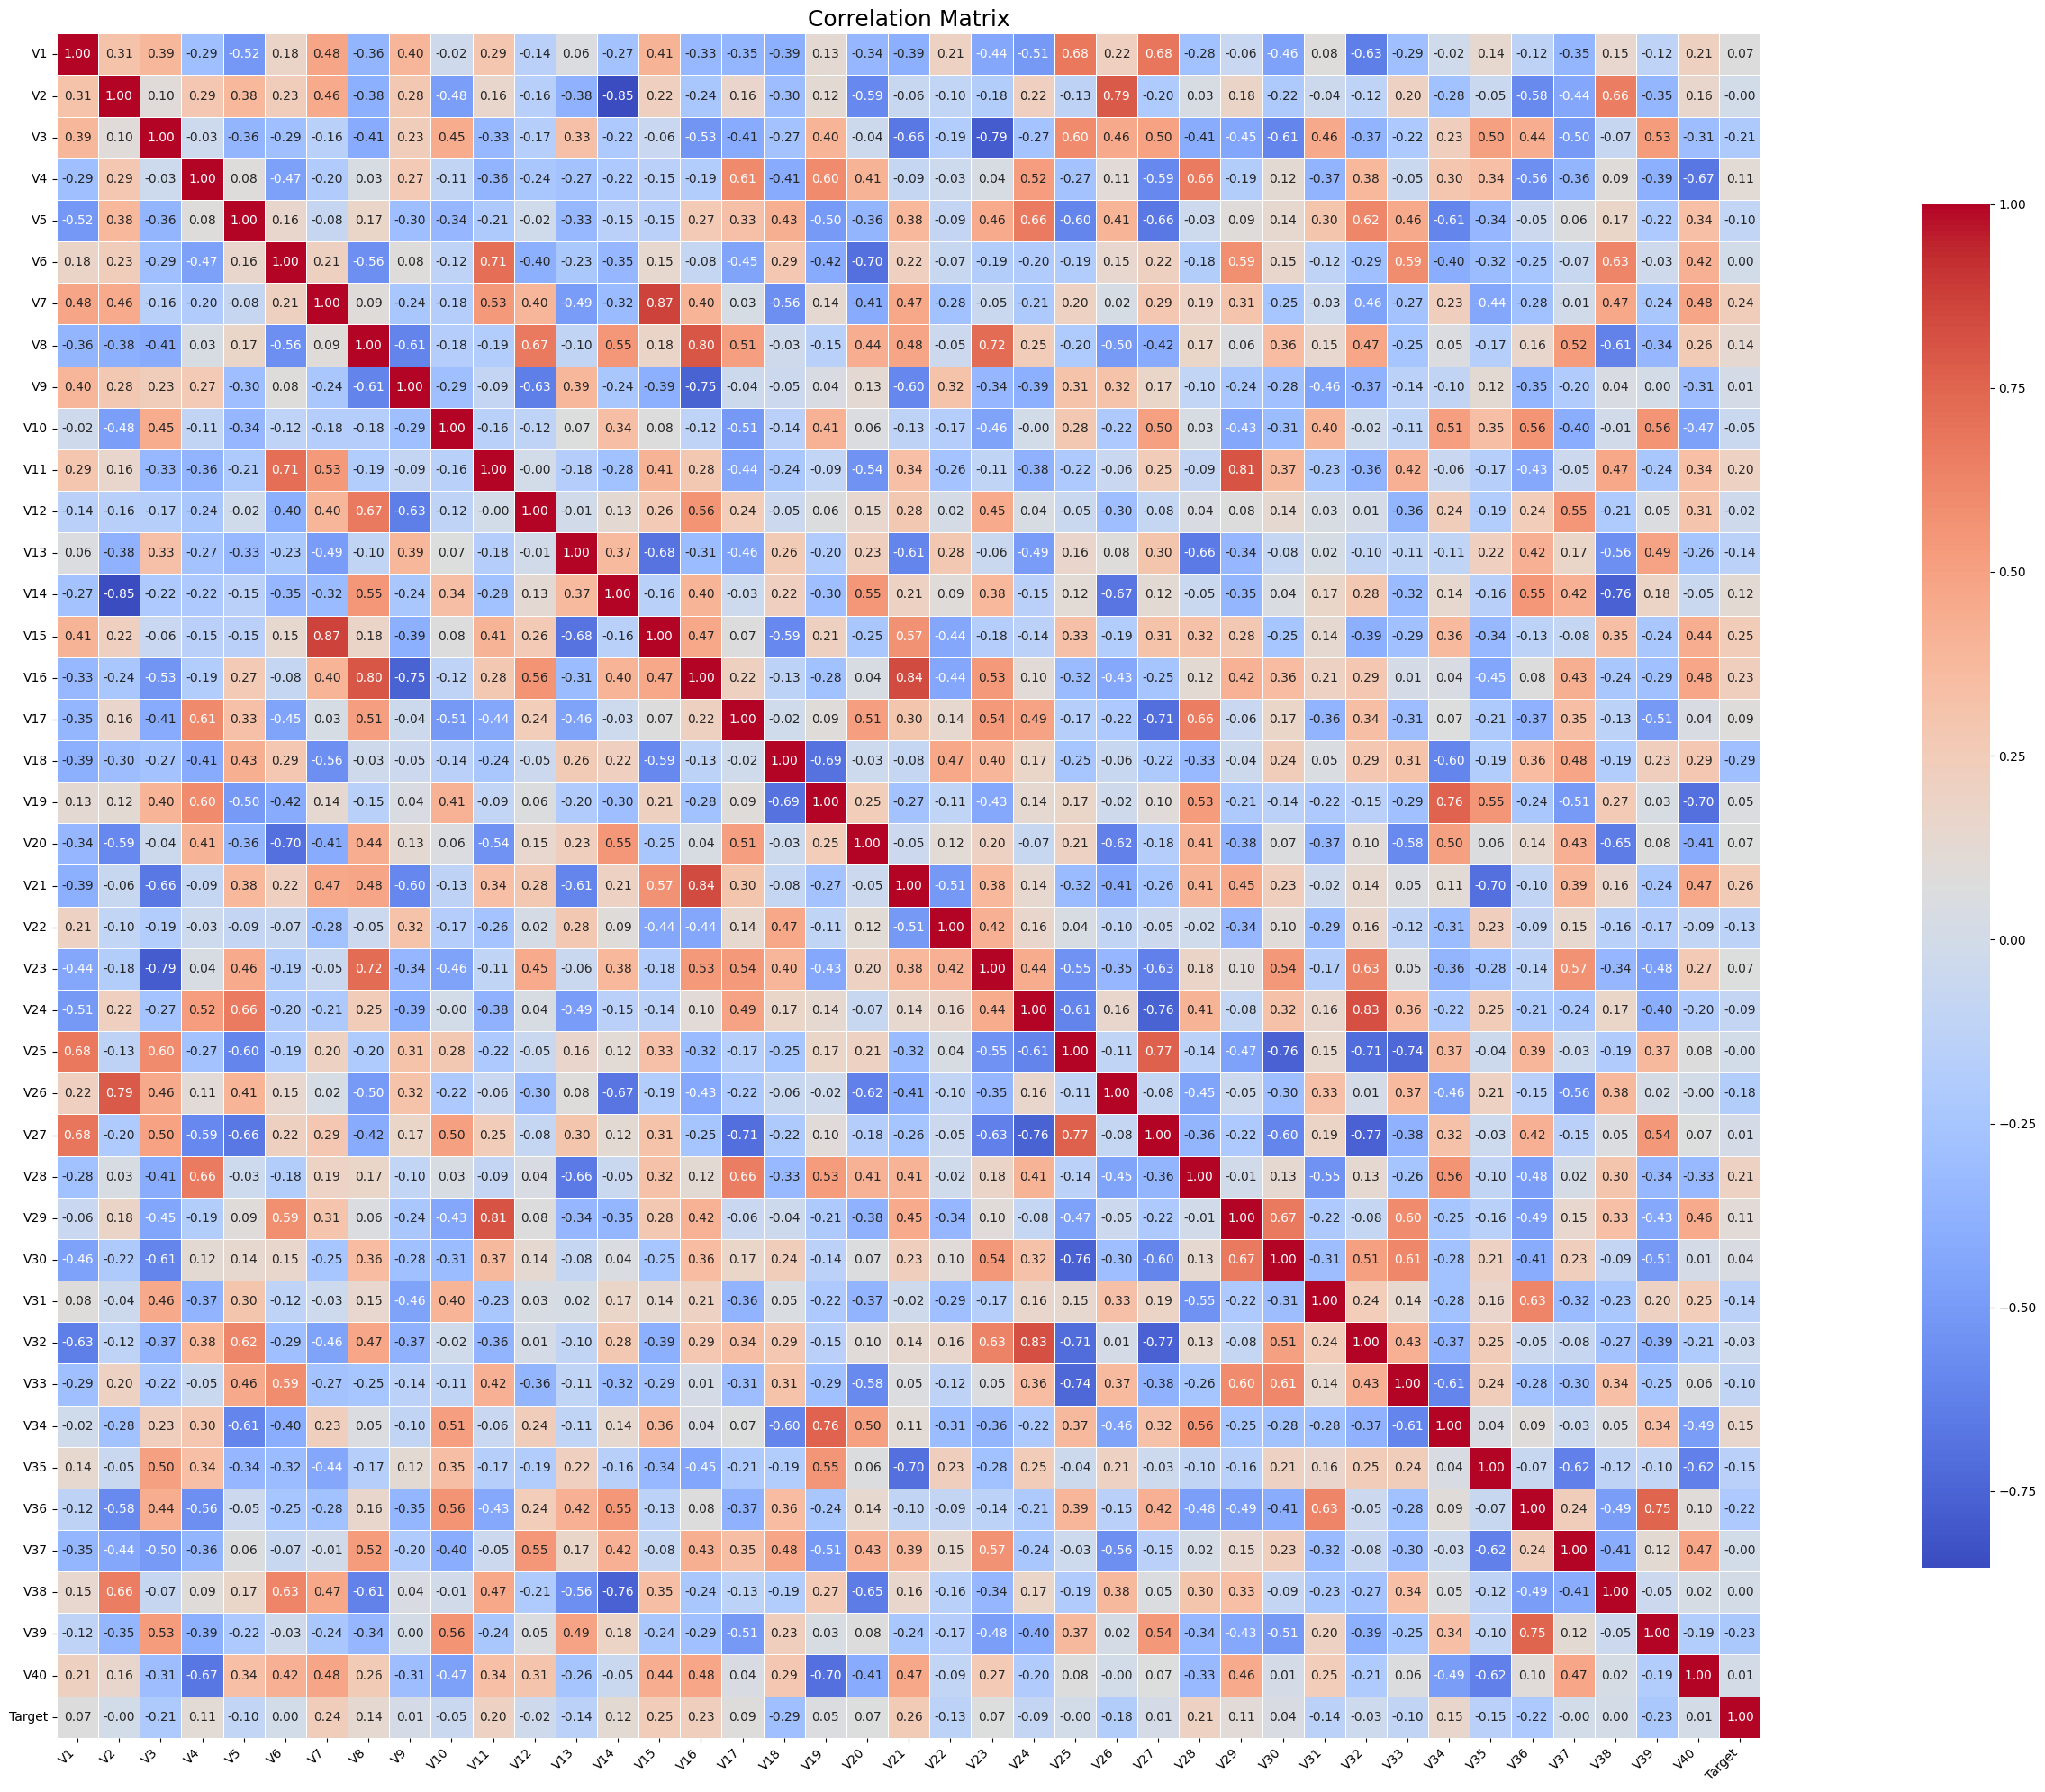

In [ ]:
# Correlation matrix (for numeric variables)
plt.figure(figsize=(36, 20))
corr = df[numeric_cols].corr()

# Full matrix
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Correlation Matrix", fontsize=18)
plt.tight_layout()
plt.show()

# **Important points**


*   None of them are strongly corelated with one another.



# As we can see that the numbers of 0's and 1's in 'Target' column is not same, so **imbalanced data**.

# So model's evaluation is based on **F1 score**.



# **Data Preprocessing**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/DL PROJECT/train.csv')

# Step 1: Split into features & target

target_col = 'Target'
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 2: Train–Validation Split (no data leakage)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.nunique() < 10 else None
)

# Step 3: Identify column types

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Step 4: Define preprocessing pipelines

# For numeric columns
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# For categorical columns
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine both
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Step 5: Fit only on training data (no leakage!)

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Confirm shapes
print("X_train_processed shape:", X_train_processed.shape)
print("X_val_processed shape:", X_val_processed.shape)

# Checking for missing value
print("Train Set - Missing:", np.isnan(X_train_processed).sum())
print("Validation Set - Missing:", np.isnan(X_val_processed).sum())

if np.isnan(X_train_processed).sum() == 0 and np.isnan(X_val_processed).sum() == 0:
    print("\nNo missing values found in processed data.")
else:
    print("\nMissing values still exist. Check imputation steps.")

X_train_processed shape: (16000, 40)
X_val_processed shape: (4000, 40)
Train Set - Missing: 0
Validation Set - Missing: 0

No missing values found in processed data.


# **Important point**


*   Split the dataset into training set and validation set in 80:20 ratio.
*   No missing values are present(missing values are replaced by pipeline method).





# **Model Building**

In [ ]:
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

To generate same random number for each model

Epoch 1/47


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9132 - loss: 0.2208 - val_accuracy: 0.9770 - val_loss: 0.0860
Epoch 2/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9737 - loss: 0.0953 - val_accuracy: 0.9858 - val_loss: 0.0650
Epoch 3/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9804 - loss: 0.0786 - val_accuracy: 0.9885 - val_loss: 0.0575
Epoch 4/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9818 - loss: 0.0736 - val_accuracy: 0.9900 - val_loss: 0.0516
Epoch 5/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9839 - loss: 0.0666 - val_accuracy: 0.9902 - val_loss: 0.0507
Epoch 6/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9850 - loss: 0.0661 - val_accuracy: 0.9910 - val_loss: 0.0486
Epoch 7/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9864 - loss: 0.0616 - val_accuracy: 0.9915 - val_loss: 0.0470
Epoch 8/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9871 - loss: 0.0606 - val_accuracy: 0.9920 - val_

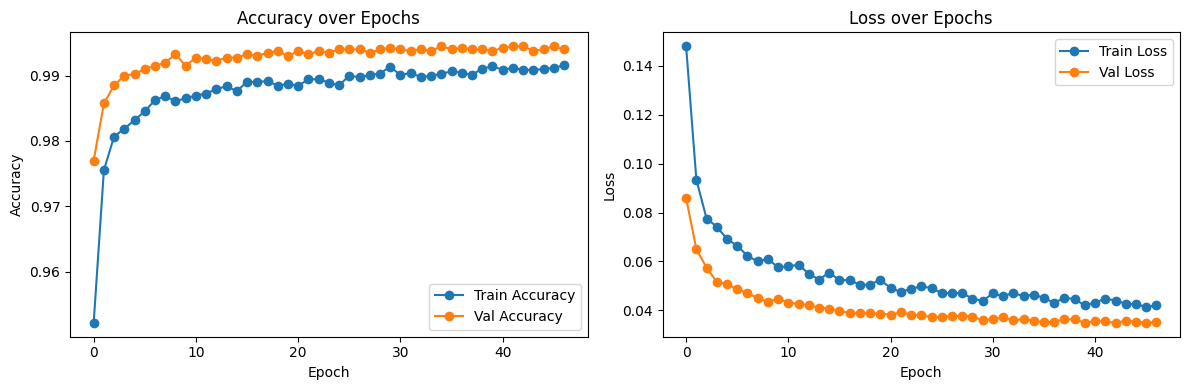

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Define Neural Network Model
input_dim = X_train_processed.shape[1]  # Number of features

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile with SGD optimizer
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_processed, y_train,
                    validation_data=(X_val_processed, y_val),
                    epochs=47,
                    batch_size=32,
                    verbose=1)

# Evaluate on validation data
y_val_pred_prob = model.predict(X_val_processed).flatten()
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Performance metrics — only F1-score and related reports
print("F1-score:", f1_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 4))

**F1 score of the above model is 0.9436619718309859.**

# **Model Performance Improvement and Final Model Selection**

Some parameters are same for each model:

1.   Epoch = 47
2.   Batch size = 32

2.   Loss function = Binary crossentropy

1.   Activation function :

*   for hidden layer, ReLU
*   for output layer, Sigmoid

5.   Learning rate = 0.01







# **MODEL 1**

Number of layers = 3,
Optimizer = SGD



Epoch 1/47


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9391 - loss: 0.2115 - val_accuracy: 0.9800 - val_loss: 0.0864
Epoch 2/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9737 - loss: 0.0974 - val_accuracy: 0.9852 - val_loss: 0.0659
Epoch 3/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9783 - loss: 0.0805 - val_accuracy: 0.9880 - val_loss: 0.0576
Epoch 4/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9820 - loss: 0.0723 - val_accuracy: 0.9890 - val_loss: 0.0538
Epoch 5/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9854 - loss: 0.0669 - val_accuracy: 0.9900 - val_loss: 0.0509
Epoch 6/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9860 - loss: 0.0629 - val_accuracy: 0.9912 - val_loss: 0.0483
Epoch 7/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9840 - loss: 0.0672 - val_accuracy: 0.9915 - val_loss: 0.0469
Epoch 8/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9874 - loss: 0.0564 - val_accuracy: 0.9918 - val_

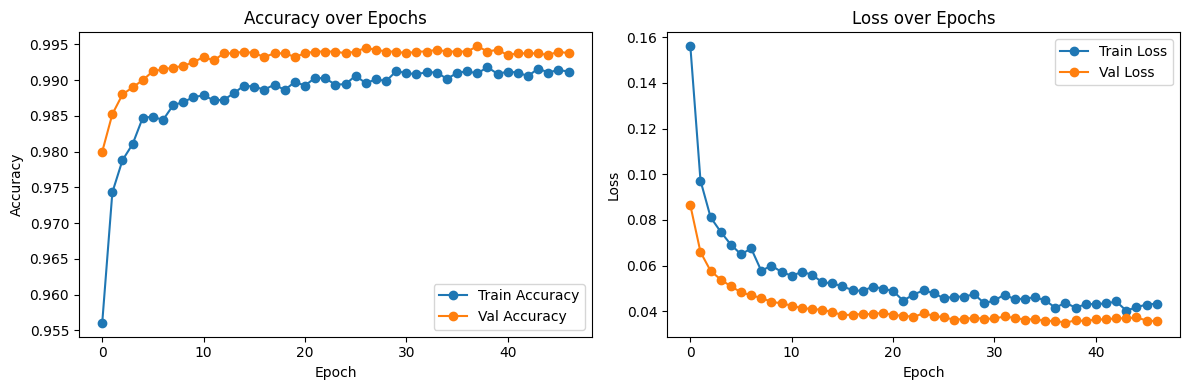

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Define Neural Network Model
input_dim = X_train_processed.shape[1]  # Number of features

model_1 = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile with SGD optimizer
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model_1.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_1.fit(X_train_processed, y_train,
                    validation_data=(X_val_processed, y_val),
                    epochs=47,
                    batch_size=32,
                    verbose=1)

# Evaluate on validation data
y_val_pred_prob = model_1.predict(X_val_processed).flatten()
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Performance metrics — only F1-score and related reports
print("F1-score:", f1_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

f1 = []
f1.append(f1_score(y_val, y_val_pred))
print('f1', f1)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 4))

**F1 score of model 1 is 0.9417249417249417.**

# **Model 2**

Number of layers = 5,
Optimizer = Adam

Epoch 1/47


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9507 - loss: 0.2051 - val_accuracy: 0.9790 - val_loss: 0.0914
Epoch 2/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9751 - loss: 0.1089 - val_accuracy: 0.9830 - val_loss: 0.0782
Epoch 3/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9792 - loss: 0.1026 - val_accuracy: 0.9803 - val_loss: 0.0959
Epoch 4/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9720 - loss: 0.1215 - val_accuracy: 0.9808 - val_loss: 0.0956
Epoch 5/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9748 - loss: 0.1243 - val_accuracy: 0.9868 - val_loss: 0.0731
Epoch 6/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9759 - loss: 0.1285 - val_accuracy: 0.9855 - val_loss: 0.0775
Epoch 7/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9756 - loss: 0.1244 - val_accuracy: 0.9720 - val_loss: 0.1254
Epoch 8/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9719 - loss: 0.1359 - val_accuracy: 0.9790 - val_

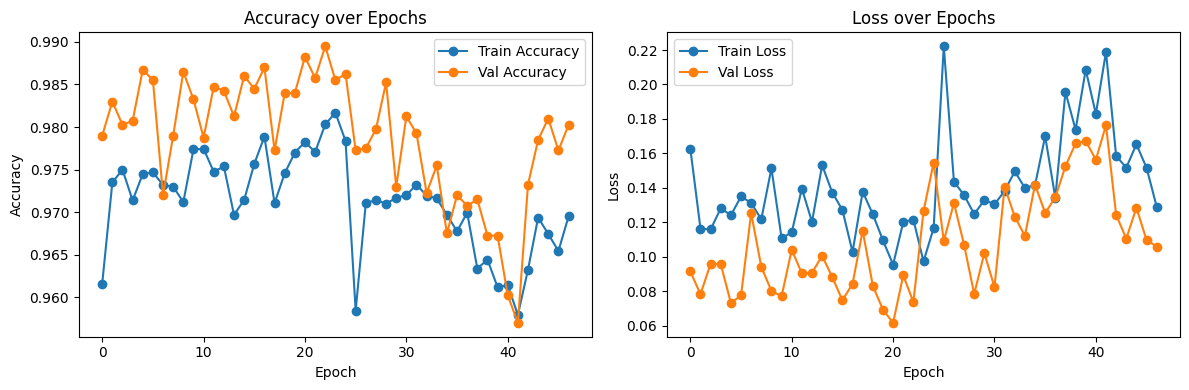

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [ ]:
from tensorflow.keras.optimizers import Adam

# Define Neural Network Model
input_dim = X_train_processed.shape[1]  # Number of features

model_2 = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile with Adam optimizer
optimizer = Adam(learning_rate=0.01)
model_2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_2.fit(X_train_processed, y_train,
                    validation_data=(X_val_processed, y_val),
                    epochs=47,
                    batch_size=32,
                    verbose=1)

# Evaluate on validation data
y_val_pred_prob = model_2.predict(X_val_processed).flatten()
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Performance metrics — only F1-score and related reports
print("F1-score:", f1_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

f1.append(f1_score(y_val, y_val_pred))
print('f1', f1)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 4))

**F1 score of model 2 is 0.7882037533512064.**

# **Model 3**

Number of hidden layers = 7, Optimizer = Adam

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9441 - loss: 0.3019 - val_accuracy: 0.9445 - val_loss: 0.1697
Epoch 2/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9470 - loss: 0.2160 - val_accuracy: 0.9445 - val_loss: 0.2131
Epoch 3/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9474 - loss: 0.2334 - val_accuracy: 0.9445 - val_loss: 0.2144
Epoch 4/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9474 - loss: 0.2890 - val_accuracy: 0.9445 - val_loss: 0.2366
Epoch 5/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9480 - loss: 0.2255 - val_accuracy: 0.9445 - val_loss: 0.2145
Epoch 6/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9481 - loss: 0.2044 - val_accuracy: 0.9445 - val_loss: 0.2145
Epoch 7/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9481 - loss: 0.2044 - val_accuracy: 0.9445 - val_loss: 0.2145
Epoch 8/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9481 - loss: 0.2045 - val_

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


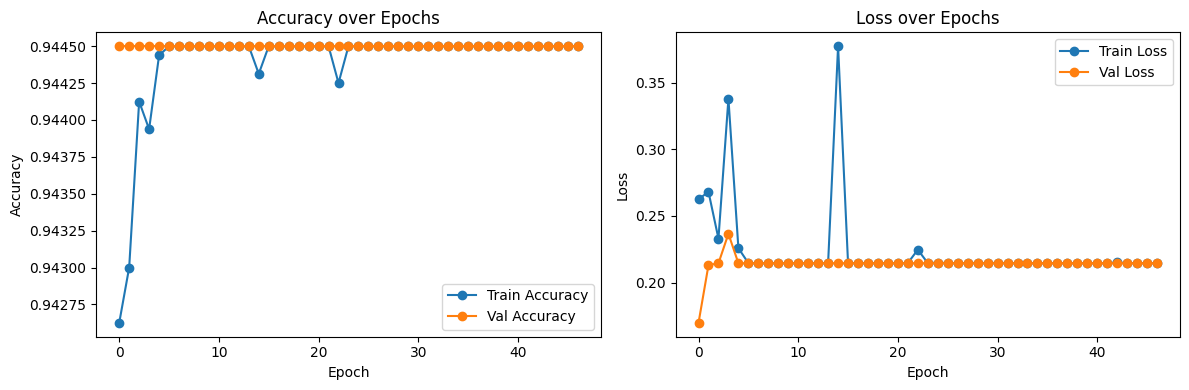

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [ ]:
# Define Neural Network Model
input_dim = X_train_processed.shape[1]  # Number of features

model_3 = Sequential([
    Dense(1024, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with Adam optimizer
optimizer = Adam(learning_rate=0.01)
model_3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_3.fit(X_train_processed, y_train,
                    validation_data=(X_val_processed, y_val),
                    epochs=47,
                    batch_size=32,
                    verbose=1)

# Evaluate on validation data
y_val_pred_prob = model_3.predict(X_val_processed).flatten()
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Performance metrics — only F1-score and related reports
print("F1-score:", f1_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

f1.append(f1_score(y_val, y_val_pred))
print('f1', f1)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 4))

**F1 score of model 3 is 0.0 due to *overtraining*.**

# **Model 4**

Same as Model 3 + Class weight

*Class weight*

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights_array))

Epoch 1/47


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7408 - loss: 1.0339 - val_accuracy: 0.9010 - val_loss: 0.4392
Epoch 2/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9237 - loss: 0.5475 - val_accuracy: 0.9457 - val_loss: 0.6669
Epoch 3/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9007 - loss: 0.6464 - val_accuracy: 0.0555 - val_loss: 0.7165
Epoch 4/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5488 - loss: 0.6729 - val_accuracy: 0.0555 - val_loss: 0.7184
Epoch 5/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5378 - loss: 0.6742 - val_accuracy: 0.0555 - val_loss: 0.7192
Epoch 6/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5378 - loss: 0.6748 - val_accuracy: 0.0555 - val_loss: 0.7193
Epoch 7/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5388 - loss: 0.6732 - val_accuracy: 0.0555 - val_loss: 0.7194
Epoch 8/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5404 - loss: 0.6729 - val_accuracy: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


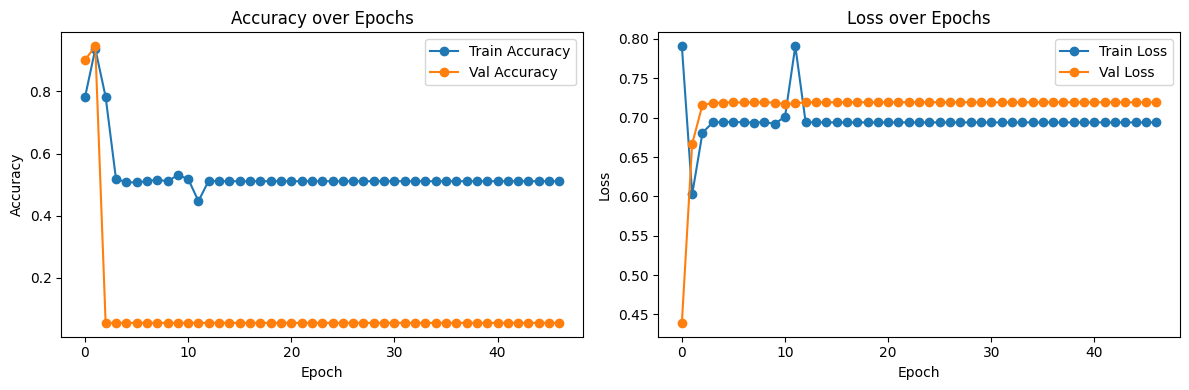

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [ ]:
# Define Neural Network Model
input_dim = X_train_processed.shape[1]  # Number of features

model_4 = Sequential([
    Dense(1024, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with Adam optimizer
optimizer = Adam(learning_rate=0.01)
model_4.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_4.fit(X_train_processed, y_train,
                    validation_data=(X_val_processed, y_val),
                    epochs=47,
                    batch_size=32,
                    verbose=1,
                    class_weight=class_weight)

# Evaluate on validation data
y_val_pred_prob = model_4.predict(X_val_processed).flatten()
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Performance metrics — only F1-score and related reports
print("F1-score:", f1_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

f1.append(f1_score(y_val, y_val_pred))
print('f1', f1)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 4))

**F1 score of model 4 is 0.10516342965419233.**

# **Model 5**

Number of layers = 2,
Optimizer = Adam

Epoch 1/47


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9655 - loss: 0.1267 - val_accuracy: 0.9795 - val_loss: 0.0877
Epoch 2/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9855 - loss: 0.0696 - val_accuracy: 0.9785 - val_loss: 0.0846
Epoch 3/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9868 - loss: 0.0637 - val_accuracy: 0.9770 - val_loss: 0.0867
Epoch 4/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9876 - loss: 0.0605 - val_accuracy: 0.9745 - val_loss: 0.0934
Epoch 5/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9877 - loss: 0.0590 - val_accuracy: 0.9755 - val_loss: 0.0920
Epoch 6/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9882 - loss: 0.0582 - val_accuracy: 0.9770 - val_loss: 0.0907
Epoch 7/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9889 - loss: 0.0573 - val_accuracy: 0.9778 - val_loss: 0.0860
Epoch 8/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9882 - loss: 0.0563 - val_accuracy: 0.9803 - val_

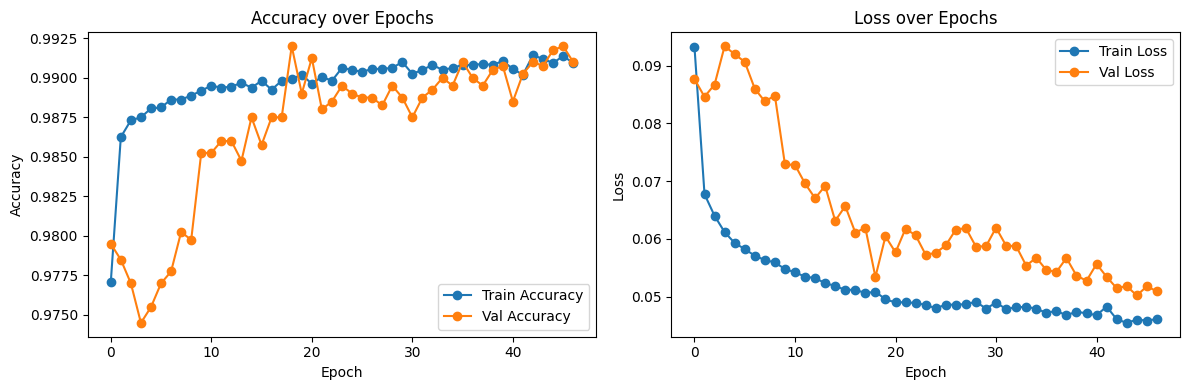

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [ ]:
# Define Neural Network Model
input_dim = X_train_processed.shape[1]  # Number of features

model_5 = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dense(1, activation='sigmoid')
])

# Compile with Adam optimizer
optimizer = Adam(learning_rate=0.01)
model_5.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_5.fit(X_train_processed, y_train,
                    validation_data=(X_val_processed, y_val),
                    epochs=47,
                    batch_size=32,
                    verbose=1)

# Evaluate on validation data
y_val_pred_prob = model_5.predict(X_val_processed).flatten()
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Performance metrics — only F1-score and related reports
print("F1-score:", f1_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

f1.append(f1_score(y_val, y_val_pred))
print('f1', f1)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 4))

**F1 score of model 5 is 0.9181818181818182.**

# **Model 6**

Number of layers = 7,
Optimizer = Adam,
Early stopping with patience = 5

Epoch 1/47


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9298 - loss: 0.2949 - val_accuracy: 0.9445 - val_loss: 0.1602
Epoch 2/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9555 - loss: 0.1611 - val_accuracy: 0.9740 - val_loss: 0.1228
Epoch 3/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9676 - loss: 0.1284 - val_accuracy: 0.9855 - val_loss: 0.0691
Epoch 4/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9717 - loss: 0.1144 - val_accuracy: 0.9743 - val_loss: 0.1105
Epoch 5/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9638 - loss: 0.1552 - val_accuracy: 0.9445 - val_loss: 0.2004
Epoch 6/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9609 - loss: 0.1700 - val_accuracy: 0.9862 - val_loss: 0.0764
Epoch 7/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9607 - loss: 0.1651 - val_accuracy: 0.9682 - val_loss: 0.1201
Epoch 8/47
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9645 - loss: 0.1316 - val_accuracy: 0.9570 - val_

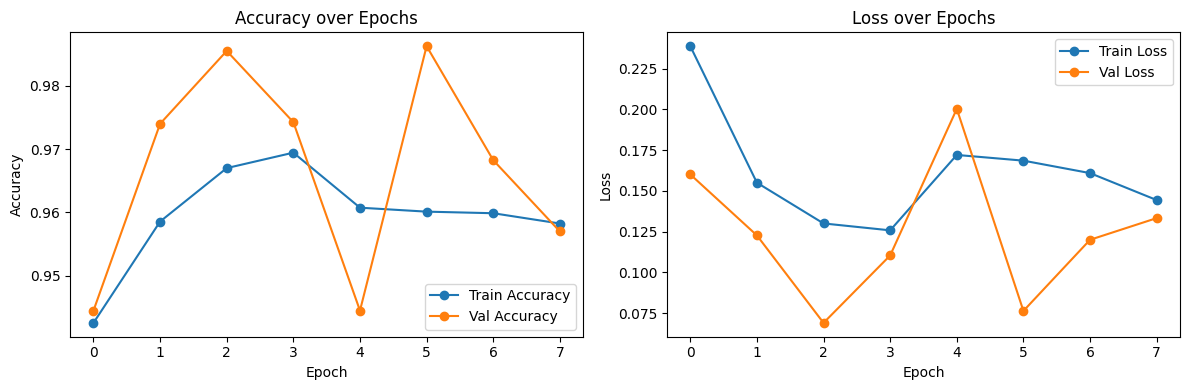

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Neural Network Model
input_dim = X_train_processed.shape[1]  # Number of features

model_6 = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with Adam optimizer
optimizer = Adam(learning_rate=0.01)
model_6.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model
history = model_6.fit(X_train_processed, y_train,
                    validation_data=(X_val_processed, y_val),
                    epochs=47,
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stopping])

# Evaluate on validation data
y_val_pred_prob = model_6.predict(X_val_processed).flatten()
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Performance metrics
print("F1-score:", f1_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

f1.append(f1_score(y_val, y_val_pred))
print('f1', f1)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**F1 score of model 6 is 0.8651162790697674.**

# **Best model**

**Finding the best model**

In [ ]:
print(f1)

[0.9417249417249417, 0.7882037533512064, 0.0, 0.10516342965419233, 0.9181818181818182, 0.8651162790697674]


In [ ]:
print(max(f1))

0.9417249417249417


In [ ]:
d = f1.index(max(f1))
print(d)

0


In [ ]:
e = d+1
best_model = 'Model_'+str(e)
print('Best model:', best_model, 'with f1 score of', max(f1), '.')

Best model: Model_1 with f1 score of 0.9417249417249417 .


**Save the best model**

In [ ]:
model_name = 'Model_' + str(e)
model.save(model_name + '.h5')

**Now train with test dataset with pre-trained best model**

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
F1 Score: 0.9190207156308852
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      4718
           1       0.98      0.87      0.92       282

    accuracy                           0.99      5000
   macro avg       0.99      0.93      0.96      5000
weighted avg       0.99      0.99      0.99      5000

Confusion Matrix:
 [[4713    5]
 [  38  244]]


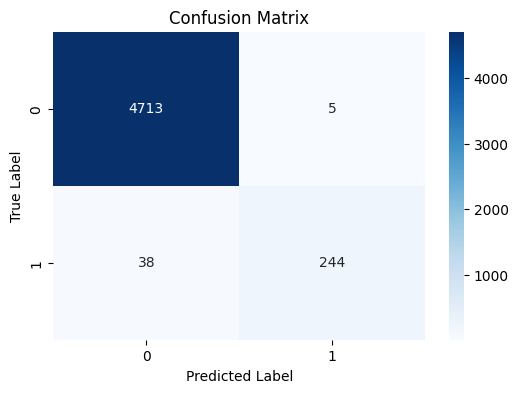

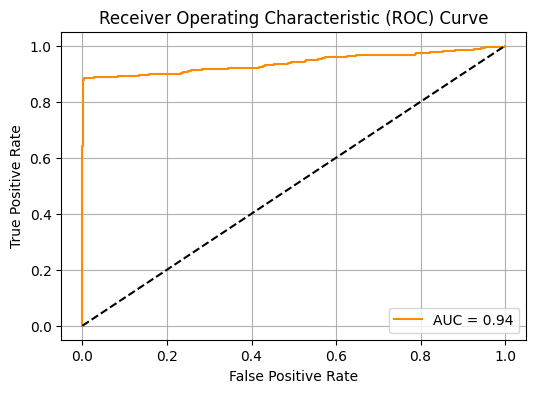

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/DL PROJECT/Test.csv')
X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col]
X_test_processed = preprocessor.transform(X_test)

from tensorflow.keras.models import load_model
model_path = model_name + '.h5'
model = load_model(model_path)

# Predict
y_test_prob = model.predict(X_test_processed).flatten()
y_test_pred = (y_test_prob > 0.5).astype(int)

# Evaluate
print("F1 Score:", f1_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# **Conclusion**



1.   Increasing number of hidden layers leads tto overfitting
2.   For imbalanced dataset, the performance metric is f1 score

1.   Best model is able to predict the failure of generator before time with the confidence of **92%**, so this will able to repair the generator before the failure of generator
2.   In this way, the company is able to maximize the production of wind energy.





# **Converting to HTML**

In [ ]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")